In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from transformers import pipeline

# Stuff important to custom Naive Bayes specifically
import pickle
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

## Last pre-processing

Put them into lists

In [21]:
pos_df = pd.read_csv("../model-files/positive-cleaned.csv", encoding='ISO-8859-1')
neg_df = pd.read_csv("../model-files/negative-cleaned.csv", encoding='ISO-8859-1')
pos_df = pos_df.iloc[:, [0, 2]] # Don't want the data from before processing
neg_df = neg_df.iloc[:, [0, 2]]
pos_df

/var/folders/wh/j0mpnsjn5dn3d140byhbb9h80000gn/T/ipykernel_8714/3027649653.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  neg_df = pd.read_csv("../model-files/negative-cleaned.csv", encoding='ISO-8859-1')


,target,clean
0,1.0,real good moment miss much
1,1.0,reading manga URL
2,1.0,URL URL
3,1.0,need send em accountant tomorrow oddly even re...
4,1.0,URL myspace myspace com lookthunder
...,...,...
277541,1.0,chris great hear due time amp reminder indeed ...
277542,1.0,thanks shout great aboard
277543,1.0,hey long URL talk
277544,1.0,matt would say URL adulthood URL


In [22]:
neg_df

,target,clean
0,0.0,lack understanding small significant part caus...
1,0.0,told parent depression hard get gen people und...
2,0.0,depression something speak even going also dou...
3,0.0,made tortilla filled pb depression cured olivi...
4,0.0,gon na need depression med soon rainouts spinn...
...,...,...
269530,0.0,wan na change avi usanele
269531,0.0,puppy broke foot
269532,0.0,jaebum baby picture
269533,0.0,mr ahmad maslan cook URL


In [23]:
pos_df.dtypes

target    float64
clean      object
dtype: object

In [24]:
neg_df.dtypes

target    object
clean     object
dtype: object

In [25]:
pos_df['target'] = pos_df['target'].astype(str)
# Filter rows where 'target' is '1.0' or '0.0'
pos_df = pos_df[pos_df['target'].isin(['1.0', '0.0'])]

neg_df['target'] = neg_df['target'].astype(str)
# Filter rows where 'target' is '1.0' or '0.0'
neg_df = neg_df[neg_df['target'].isin(['1.0', '0.0'])]

In [26]:
pos_df['target'] = pos_df['target'].map(float)
neg_df['target'] = neg_df['target'].map(float)

positive_text, positive_sentiment = list(pos_df['clean']), list(pos_df['target']) # Turn these both into lists
negative_text, negative_sentiment = list(neg_df['clean']), list(neg_df['target'])

positive_text = [str(item) for item in positive_text]
negative_text = [str(item) for item in negative_text]
positive_sentiment = [int(num) for num in positive_sentiment]
negative_sentiment = [int(num) for num in negative_sentiment]

print(negative_text[0].split())

/var/folders/wh/j0mpnsjn5dn3d140byhbb9h80000gn/T/ipykernel_8714/1784079681.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_df['target'] = neg_df['target'].map(float)


['lack', 'understanding', 'small', 'significant', 'part', 'cause', 'anxiety', 'depression', 'feel', 'incredibly', 'lonely', 'soo', 'easy', 'compare', 'easy', 'invalidate']


## Word cloud for positive and negative text

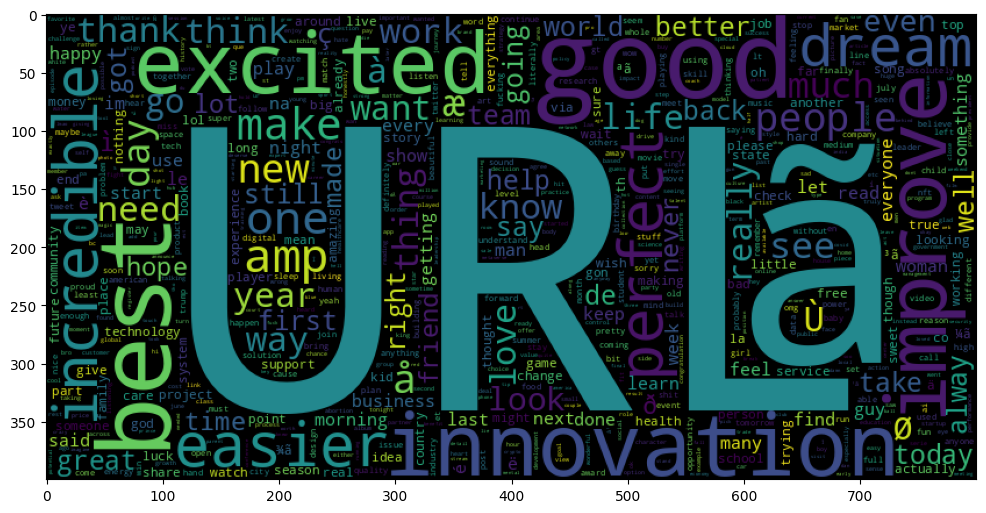

In [27]:
# Positive text
plt.figure(figsize = (12,12))
wc = WordCloud(max_words = 1000 , width = 800 , height = 400,
               collocations=False).generate(" ".join(positive_text))
plt.imshow(wc)

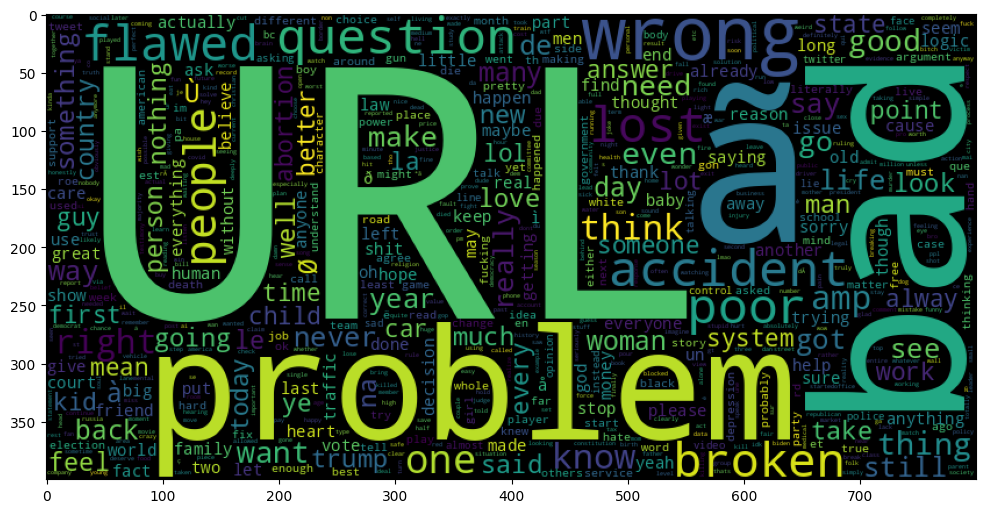

In [28]:
# Positive text
plt.figure(figsize = (12,12))
wc = WordCloud(max_words = 1000 , width = 800 , height = 400,
               collocations=False).generate(" ".join(negative_text))
plt.imshow(wc)

## URL and a don't make sense, don't consider them during naive bayes training

In [29]:
with open("../model-files/stop-words.txt") as f:
    stopwords = [line.strip() for line in f]
stopwords = set(stopwords)
stopwords # Check the stop words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

## Naive Bayes

Implement Naive Bayes from scratch BUT also consider bigrams

In [219]:
import re # Regex for the Naive Bayes model
from nltk.stem import WordNetLemmatizer # WordNetLemmatizer for the Naive Bayes model
from nltk.tokenize import word_tokenize # Also for Naive Bayes model
class NaiveBayesClassifier:
    def __init__(self):
        with open("../model-files/stop-words.txt") as f:
            self.stopwords = [line.strip() for line in f]
        self.stopwords = set(self.stopwords) # Set of stop words to check against for the clean method for each prediction, keep in mind this model takes in cleaned data so should only be used for prediction

        with open("../model-files/negation-words.txt") as f:
            self.negationwords = [line.strip() for line in f]
        self.negationwords = set(self.negationwords)

        self.negative_word_count = 0 # Total number of words for each class
        self.positive_word_count = 0
        self.positive_words = {}  # Word frequencies for each class
        self.negative_words = {}

        self.positive_bigram_count = 0
        self.negative_bigram_count = 0
        self.positive_bigrams = {}
        self.negative_bigrams = {}


    def clean(self, text):        
        # Convert to lowercase
        message = text.lower()
        # Remove URLs. Match words that begin with http, http\S+, www, etc... and \S+ which is just one or more non-whitespace characters
        message = re.sub(r'\shttp\S+|\swww\S+|\shttps\S+', ' URL ', message, flags=re.MULTILINE)

        # Do they same as above but match with anything that ends with .com, .net, or website endings
        message = re.sub(r'\S+.com\s|\S+.net\s|\S+.org\s|\S+.co\s|\S+.us\s|\S+.edu\s|\S+.me\s|\S+.cn\s|\S+.uk\s|\S+.cn\s', ' URL ', message, flags=re.MULTILINE)
        # Get rid of @ mentions from the tweet dataset
        message = re.sub(r'@\S+', '', message, flags=re.MULTILINE)

        # Remove punctuation
        message = re.sub(r'\W', ' ', message)
        # Remove digits
        message = re.sub(r'\d+', '', message)

        # Tokenize the tweet (just store each word into a list)
        tokens = word_tokenize(message)

        tokens = [token for token in tokens if token not in self.stopwords] # Keep the ones that aren't a stop word

        # Lemmatize tokens, converting it back to its base form
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        tokens = [token for token in tokens if len(token) > 1] # Get rid of random letters out and about from punctuation removal
        return tokens # Return a list of tokens

    def fit(self, positive_text, negative_text):
        for i in range(len(positive_text)):
            splitted = positive_text[i].split()
            for j in range(len(splitted)):
                if splitted[j] not in self.positive_words: # Keep track of 
                    self.positive_words[splitted[j]] = 0
                self.positive_words[splitted[j]] += 1
                self.positive_word_count += 1

                if j < len(splitted) - 1: # We can count bigrams
                    self.positive_bigram_count += 1
                    curr = splitted[j] + splitted[j+1]
                    if curr not in self.positive_bigrams:
                        self.positive_bigrams[curr] = 0
                    self.positive_bigrams[curr] += 1

        for i in range(len(negative_text)):
            splitted = negative_text[i].split()
            for j in range(len(splitted)):
                if splitted[j] not in self.negative_words:
                    self.negative_words[splitted[j]] = 0
                self.negative_words[splitted[j]] += 1
                self.negative_word_count += 1

                if j < len(splitted) - 1: # We can count bigrams
                    self.negative_bigram_count += 1
                    curr = splitted[j] + splitted[j+1]
                    if curr not in self.negative_bigrams:
                        self.negative_bigrams[curr] = 0
                    self.negative_bigrams[curr] += 1

        self.positive_word_count -= self.positive_words['URL']
        self.negative_word_count -= self.negative_words['URL']
        self.positive_words.pop('URL') # Two most common words for both categories, doesn't make sense
        self.negative_words.pop('URL')
        self.positive_words.pop('ã') 
        self.negative_words.pop('ã')
    
    def predict(self, text): # VERY similar to data preprocessing, 1. Preprocess 2. Run inference based off the words
        tokens = self.clean(text) # Clean the message and get tokens in the form that we want
        pos_word_prob = 1
        neg_word_prob = 1
        pos_bigram_prob = 1
        neg_bigram_prob = 1
        for i in range(len(tokens)):
            if tokens[i] in self.positive_words and tokens[i] in self.negative_words: # If this word is in both, we can simply grab it from both
                pos_word_prob *= (self.positive_words[tokens[i]] / self.positive_word_count)
                neg_word_prob *= (self.negative_words[tokens[i]] / self.negative_word_count)
            elif tokens[i] in self.positive_words: # If it's only in one of them, need to pretend we saw one of this word in the negative or positive dataset
                pos_word_prob *= (self.positive_words[tokens[i]] / self.positive_word_count)
                neg_word_prob *= (1 / (self.negative_word_count + len(self.negative_words))) # Divide by negative_word_count + number of words because we're pretending for each negative word, we saw more than we actually did to scale with the current word we are pretending exists
            elif tokens[i] in self.negative_words:
                neg_word_prob *= (self.negative_words[tokens[i]] / self.negative_word_count)
                pos_word_prob *= (1 / (self.positive_word_count + len(self.positive_words))) # Scale it up to the number of additions we need to "hallucinate"

            if i < len(tokens)-1:
                curr = tokens[i] + tokens[i+1]
                if curr in self.positive_bigrams and curr in self.negative_bigrams:
                    pos_bigram_prob *= (self.positive_bigrams[curr] / self.positive_bigram_count)
                    neg_bigram_prob *= (self.negative_bigrams[curr] / self.negative_bigram_count)
                elif curr in self.positive_bigrams:
                    pos_bigram_prob *= (self.positive_bigrams[curr] / self.positive_bigram_count)
                    neg_bigram_prob *= (1 / (self.negative_bigram_count + len(self.negative_bigrams)))
                elif curr in self.negative_bigrams:
                    pos_bigram_prob *= (1 / (self.positive_bigram_count + len(self.positive_bigrams)))
                    neg_bigram_prob *= (self.negative_bigrams[curr] / self.negative_bigram_count)
        if pos_bigram_prob == 1 or neg_bigram_prob == 1: # If we couldn't find any, just base it solely off the words themself
            pos_bigram_prob = 0
            neg_bigram_prob = 0
        final_pos = (pos_word_prob * 100) + pos_bigram_prob * 100
        final_neg = (neg_word_prob * 100) + neg_bigram_prob * 100
        print(pos_bigram_prob)
        print(neg_bigram_prob)
        text_split = text.split()
        negate = False
        if len(text_split) > 2 and (text_split[0] in self.negationwords or text_split[1] in self.negationwords): # Use my list of negation words to detect if the first couple of words are a word that negates the rest
            negate = True
        if len(text_split) > 3 and text_split[2] in self.negationwords:
            negate = True
        pos_likelihood = final_pos / (final_pos + final_neg)
        neg_likelihood = final_neg / (final_pos + final_neg)
        if final_pos > final_neg: 
            if negate: # If we found a negation word at the start, chances are simply relying on the word's probability won't cut it so negate the outcome. Ex: Don't be harsh on yourself vs. Be harsh on yourself will be distuinguished with this
                return "negative", pos_likelihood
            return "positive", pos_likelihood
        else:
            if negate:
                return "positive", neg_likelihood
            return "negative", neg_likelihood

In [220]:
import random
random.shuffle(positive_text)
random.shuffle(negative_text)
train_pos = positive_text[:200000]
train_neg = negative_text[:200000]

test_pos = positive_text[200000:] # The above should be :200000 to test the model but for the deployed model I will use all training examples
test_neg = negative_text[200000:]

In [221]:
Naive_Bayes = NaiveBayesClassifier()
Naive_Bayes.fit(train_pos, train_neg)
print("Training complete.")

Training complete.


In [223]:
message = "i hate you"
Naive_Bayes.predict(message)

0
0


('negative', 0.6321961416826091)

In [217]:
message = "KILL YOURSELF"
Naive_Bayes.predict(message)

0
0


('negative', 0.6763087108564209)

In [218]:
message = "this is a message"
Naive_Bayes.predict(message)

0
0


('negative', 0.5349876912040584)

In [224]:
message = "I eat a lot"
Naive_Bayes.predict(message)

1.3072425157097868e-06
2.0591978188976703e-06


('negative', 0.5912421852016762)

In [225]:
message = "you're terrible lol"
Naive_Bayes.predict(message)

2.790169229344098e-07
1.235518691338602e-06


('negative', 0.7959666033729882)

In [226]:
message = "dont kill yourself"
Naive_Bayes.predict(message)

4.3574750523659565e-07
1.235518691338602e-06


('positive', 0.7446538374490871)

In [228]:
message = "I dreadtimes like this"
Naive_Bayes.predict(message)

1.3508172662334464e-05
1.1943347349606488e-05


('positive', 0.530741172137069)

## Test for validation
Test the dataset to see how accurate it is

In [183]:
correct_count = 0
total = 0
for i in range(len(test_pos)):
    emotion, value = Naive_Bayes.predict(test_pos[i])
    if abs(value - 0.5) < 0.05:
        continue # Neutral
    if emotion == "positive":
        correct_count += 1
    total += 1
for i in range(len(test_neg)):
    emotion, value = Naive_Bayes.predict(test_neg[i])
    if abs(value - 0.5) < 0.05:
        continue # Neutral
    if emotion == "negative":
        correct_count += 1
    total += 1
print("Overall accuracy on validation set:", correct_count/(total))

Overall accuracy on validation set: 0.9181423950025099


In [ ]:
sentiment_pipeline = pipeline(model="cardiffnlp/twitter-roberta-base-sentiment-latest")
prediction = sentiment_pipeline(["I like you"])[0]['label']
print(prediction)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


positive


### roBERTa is too slow

In [ ]:
# Test ROBERTA accuracy
sentiment_pipeline = pipeline(model="cardiffnlp/twitter-roberta-base-sentiment-latest")
total = 0
for i in range(len(test_pos)):
    prediction = sentiment_pipeline([test_pos[i]])[0]['label']
    if emotion == "neutral":
        continue
    if emotion == "positive":
        correct_count += 1
    total += 1
for i in range(len(test_pos)):
    prediction = sentiment_pipeline([test_pos[i]])[0]['label']
    if emotion == "neutral":
        continue
    if emotion == "negative":
        correct_count += 1
    total += 1
print("Overall accuracy on validation set:", correct_count/(total))

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


KeyboardInterrupt: 

## Pickle the model for use in the bot


In [ ]:
# Pickle the Naive Bayes classifier object
with open('naive_bayes_model.pkl2', 'wb') as f:
    pickle.dump(Naive_Bayes, f)

print("Naive Bayes model saved as naive_bayes_model2.pkl")

Naive Bayes model saved as naive_bayes_model2.pkl


## Try with Multinomial Naive Bayes and Logistic Regression

These are to compare the performance under optimal conditions. I will still be using my implementation of Naive Bayes from scratch for deployment because of how lightweight it is.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(text, sentiment, test_size=0.2, random_state=42) # Get a train test split based off of Naive Bayes

In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [ ]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [ ]:
MultiNB = MultinomialNB()
MultiNB.fit(X_train, y_train)
model_Evaluate(MultiNB)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


KeyboardInterrupt: 

              precision    recall  f1-score   support

           0       0.80      0.77      0.79    159494
           1       0.78      0.81      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



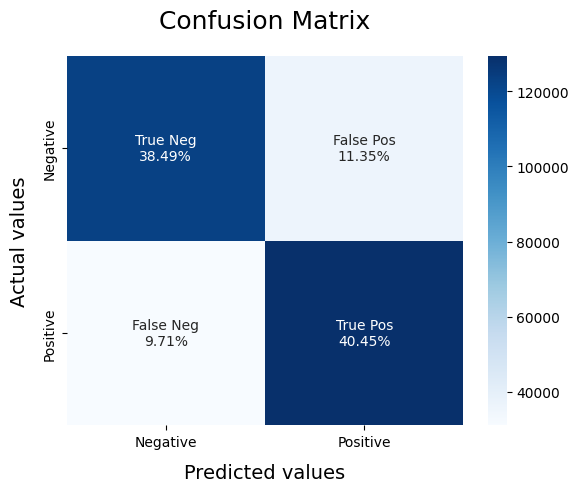

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)